Importing Libraries

In [1]:
import numpy as np
import pywt
import scipy.io
import matplotlib.pyplot as plt
from vmdpy import VMD
import itertools

Function for data loading

In [11]:
def load_emg_data(mat_file_path, variable_name='EMG'):
    mat_contents = scipy.io.loadmat(mat_file_path)
    emg_data = mat_contents[variable_name].flatten()  
    return emg_data

Function for adding gausing noise

In [3]:
def add_gaussian_noise(signal, snr_dB):
    signal_power = np.mean(signal ** 2)
    snr_linear = 10 ** (snr_dB / 10.0)
    noise_power = signal_power / snr_linear
    noise = np.sqrt(noise_power) * np.random.normal(size=signal.shape)
    noisy_signal = signal + noise
    return noisy_signal

Function for DWP denoising

In [4]:
def denoise_dwp(signal, wavelet='db4', level=4):
    wp = pywt.WaveletPacket(data=signal, wavelet=wavelet, mode='symmetric')
    nodes = wp.get_level(level, order='freq')
    coeffs = np.array([n.data for n in nodes], 'd')

    threshold = np.median(np.abs(coeffs)) / 0.6745
    denoised_coeffs = pywt.threshold(coeffs, threshold, mode='soft')

    for i, n in enumerate(nodes):
        n.data = denoised_coeffs[i]
    denoised_signal = wp.reconstruct(update=True)
    return denoised_signal

Function for VMD denoising

In [5]:
def denoise_vmd(signal, alpha=2000, tau=0, K=5, DC=0, init=1, tol=1e-7):
    downsample_factor = 10  
    signal_downsampled = signal[::downsample_factor]

    u, u_hat, omega = VMD(signal_downsampled, alpha, tau, K, DC, init, tol)
    denoised_signal_downsampled = np.sum(u, axis=0)

    denoised_signal = np.interp(np.arange(len(signal)), np.arange(0, len(signal), downsample_factor), denoised_signal_downsampled)
    
    return denoised_signal

Function for TQWT

In [42]:
import numpy as np
import pywt

def tqwt_decompose(signal, wavelet='db4', maxlevel=4):
    wp = pywt.WaveletPacket(data=signal, wavelet=wavelet, mode='symmetric', maxlevel=maxlevel)
    nodes = wp.get_level(maxlevel, order='freq')
    coeffs = [node.data for node in nodes]
    
    if len(coeffs) == 0:
        raise ValueError("No coefficients obtained from decomposition.")
    
    return coeffs, wp

def tqwt_reconstruct(coeffs, wp):
    if wp is None:
        raise ValueError("WaveletPacket object is None.")
    
    new_wp = pywt.WaveletPacket(data=None, wavelet=wp.wavelet, mode='symmetric')
    for i, node in enumerate(wp.get_level(wp.maxlevel, order='freq')):
        if len(coeffs[i]) > len(wp.data):
            coeffs[i] = coeffs[i][:len(wp.data)]
        elif len(coeffs[i]) < len(wp.data):
            coeffs[i] = np.pad(coeffs[i], (0, len(wp.data) - len(coeffs[i])), 'constant')
        
        new_wp[node.path] = coeffs[i]
    
    reconstructed_signal = new_wp.reconstruct(update=True)

    if len(reconstructed_signal) > len(wp.data):
        reconstructed_signal = reconstructed_signal[:len(wp.data)]
    elif len(reconstructed_signal) < len(wp.data):
        reconstructed_signal = np.pad(reconstructed_signal, (0, len(wp.data) - len(reconstructed_signal)), 'constant')
    
    return reconstructed_signal

def denoise_tqwt(signal, wavelet='db4', maxlevel=4):
    try:
        coeffs, wp = tqwt_decompose(signal, wavelet, maxlevel)
    except ValueError as e:
        print(f"Error in tqwt_decompose: {e}")
        return None

    for i in range(len(coeffs)):
        threshold = np.median(np.abs(coeffs[i])) / 0.6745
        coeffs[i] = pywt.threshold(coeffs[i], threshold, mode='soft')
    
    try:
        denoised_signal = tqwt_reconstruct(coeffs, wp)
    except ValueError as e:
        print(f"Error in tqwt_reconstruct: {e}")
        return None

    return denoised_signal


Function for evaluation

In [7]:
def evaluate_denoising_performance(original_signal, denoised_signal):
    noise = original_signal - denoised_signal
    snr = 10 * np.log10(np.mean(original_signal ** 2) / np.mean(noise ** 2))
    return snr

Example case

In [12]:
mat_file_path = 'EMG_all_epochs.mat'  
variable_name = 'EMG_all_epochs'  
raw_emg = load_emg_data(mat_file_path, variable_name)

Adding noise

In [13]:
snr_dB = 10  
noisy_emg = add_gaussian_noise(raw_emg, snr_dB)

Denoising

In [15]:
denoised_emg_dwp = denoise_dwp(noisy_emg)

In [16]:
denoised_emg_vmd = denoise_vmd(noisy_emg)

In [27]:
denoised_emg_tqwt = denoise_tqwt(noisy_emg)

Results section

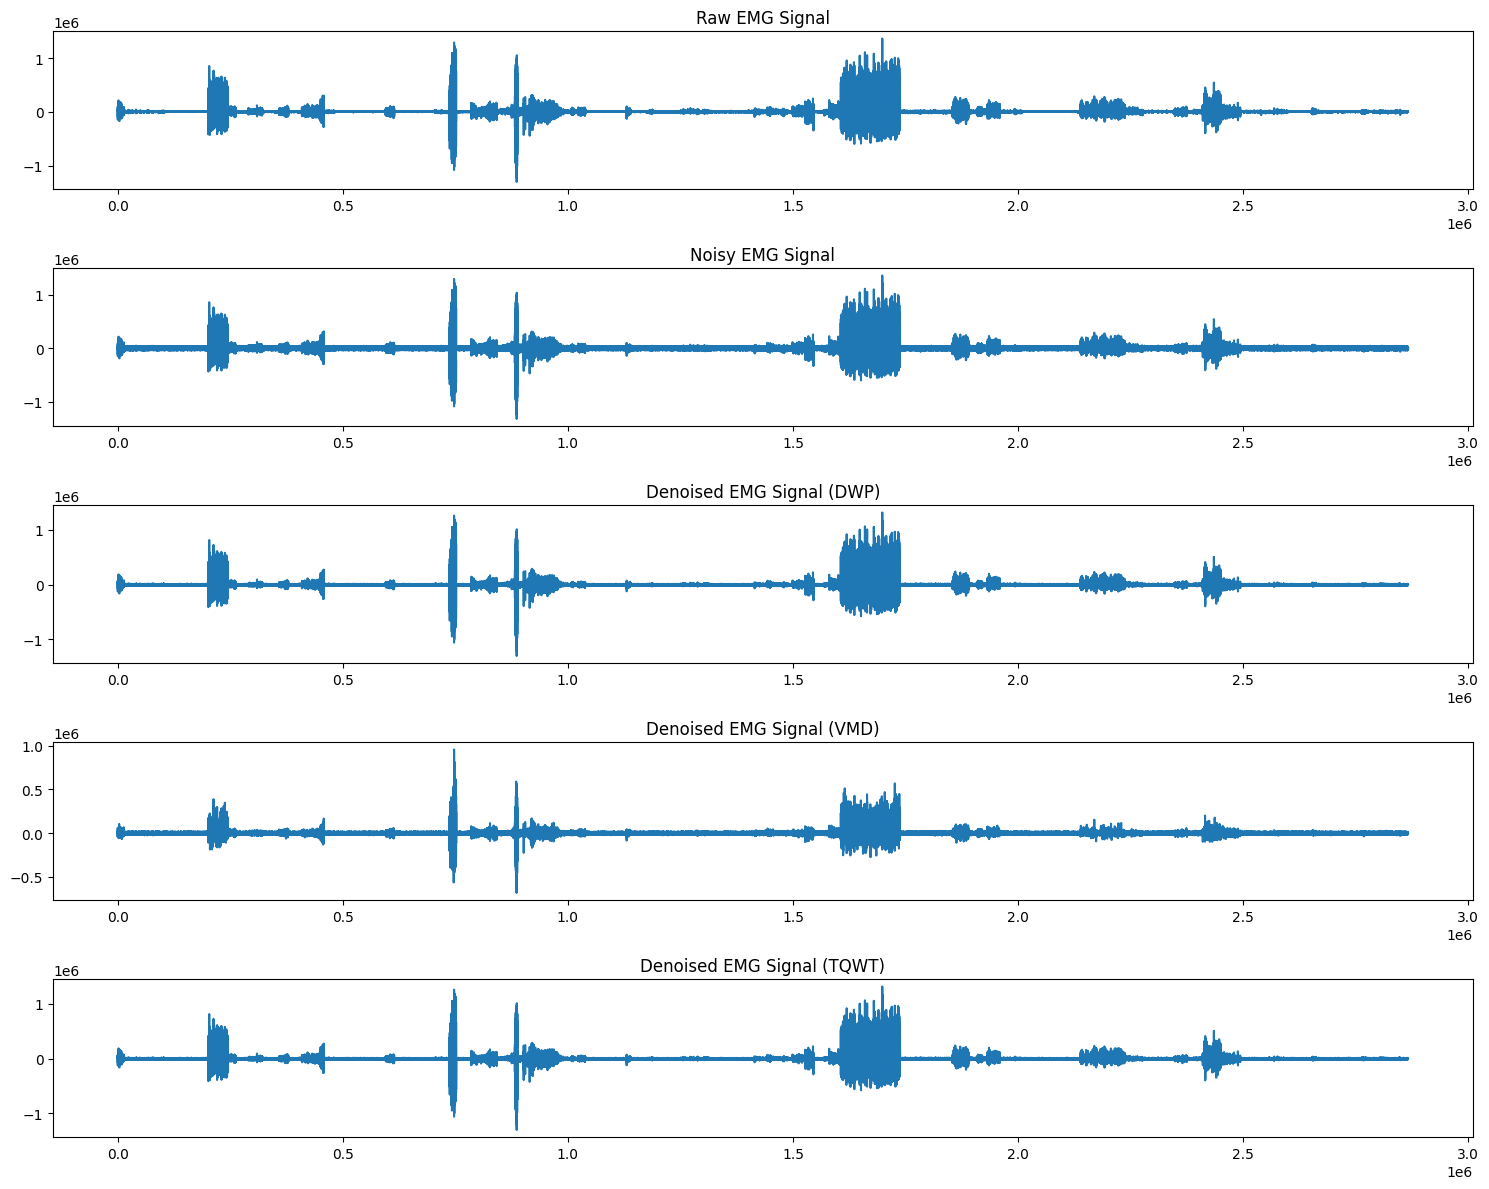

In [29]:
plt.figure(figsize=(15, 12))
plt.subplot(5, 1, 1)
plt.plot(raw_emg)
plt.title('Raw EMG Signal')
plt.subplot(5, 1, 2)
plt.plot(noisy_emg)
plt.title('Noisy EMG Signal')
plt.subplot(5, 1, 3)
plt.plot(denoised_emg_dwp)
plt.title('Denoised EMG Signal (DWP)')
plt.subplot(5, 1, 4)
plt.plot(denoised_emg_vmd)
plt.title('Denoised EMG Signal (VMD)')
plt.subplot(5, 1, 5)
plt.plot(denoised_emg_tqwt)
plt.title('Denoised EMG Signal (TQWT)')
plt.tight_layout()
plt.show()

Finetuning the parameter

In [30]:
def fine_tune_dwp(noisy_emg):
    wavelet_list = ['db2', 'db4', 'sym2', 'sym4']
    level_values = [3, 4, 5]

    best_params_dwp = None
    best_performance_dwp = -np.inf

    for wavelet, level in itertools.product(wavelet_list, level_values):
        denoised_signal = denoise_dwp(noisy_emg, wavelet=wavelet, level=level)
        performance = evaluate_denoising_performance(raw_emg, denoised_signal)
        
        if performance > best_performance_dwp:
            best_performance_dwp = performance
            best_params_dwp = (wavelet, level)
    
    return best_params_dwp, best_performance_dwp

best_params_dwp, best_performance_dwp = fine_tune_dwp(noisy_emg)

print("Best DWP parameters:", best_params_dwp)
print("Best DWP performance (SNR):", best_performance_dwp)

Best DWP parameters: ('db2', 4)
Best DWP performance (SNR): 14.074155149161896


In [31]:
def fine_tune_vmd(noisy_emg):
    alpha_values = [1000, 2000, 3000]
    tau_values = [0.1, 0.2]
    K_values = [3, 5, 7]

    best_params_vmd = None
    best_performance_vmd = -np.inf
                                  
    for alpha, tau, K in itertools.product(alpha_values, tau_values, K_values):
        denoised_signal = denoise_vmd(noisy_emg, alpha=alpha, tau=tau, K=K)
        performance = evaluate_denoising_performance(raw_emg, denoised_signal)
        
        if performance > best_performance_vmd:
            best_performance_vmd = performance
            best_params_vmd = (alpha, tau, K)

    return best_params_vmd, best_performance_vmd

best_params_vmd, best_performance_vmd = fine_tune_vmd(noisy_emg)

print("Best VMD parameters:", best_params_vmd)
print("Best VMD performance (SNR):", best_performance_vmd)

Best VMD parameters: (1000, 0.2, 5)
Best VMD performance (SNR): -1.221530140870022


In [43]:
def fine_tune_tqwt(noisy_emg):
    wavelet_list = ['db2', 'db4', 'sym2', 'sym4']
    maxlevel_values = [3, 4, 5]

    best_params_tqwt = None
    best_performance_tqwt = -np.inf

    for wavelet, maxlevel in itertools.product(wavelet_list, maxlevel_values):
        denoised_signal = denoise_tqwt(noisy_emg, wavelet=wavelet, maxlevel=maxlevel)
        performance = evaluate_denoising_performance(raw_emg, denoised_signal)
        
        if performance > best_performance_tqwt:
            best_performance_tqwt = performance
            best_params_tqwt = (wavelet, maxlevel)
    
    return best_params_tqwt, best_performance_tqwt

best_params_tqwt, best_performance_tqwt = fine_tune_tqwt(noisy_emg)

print("Best TQWT parameters:", best_params_tqwt)
print("Best TQWT performance (SNR):", best_performance_tqwt)

Best TQWT parameters: ('db2', 4)
Best TQWT performance (SNR): 14.022451595094509


Results with the best parameter

In [44]:
denoised_emg_dwp = denoise_dwp(noisy_emg, wavelet=best_params_dwp[0], level=best_params_dwp[1])
denoised_emg_vmd = denoise_vmd(noisy_emg, alpha=best_params_vmd[0], tau=best_params_vmd[1], K=best_params_vmd[2])
denoised_emg_tqwt = denoise_tqwt(noisy_emg, wavelet=best_params_tqwt[0], maxlevel=best_params_tqwt[1])

Text(0.5, 1.0, 'Denoised EMG Signal (TQWT)')

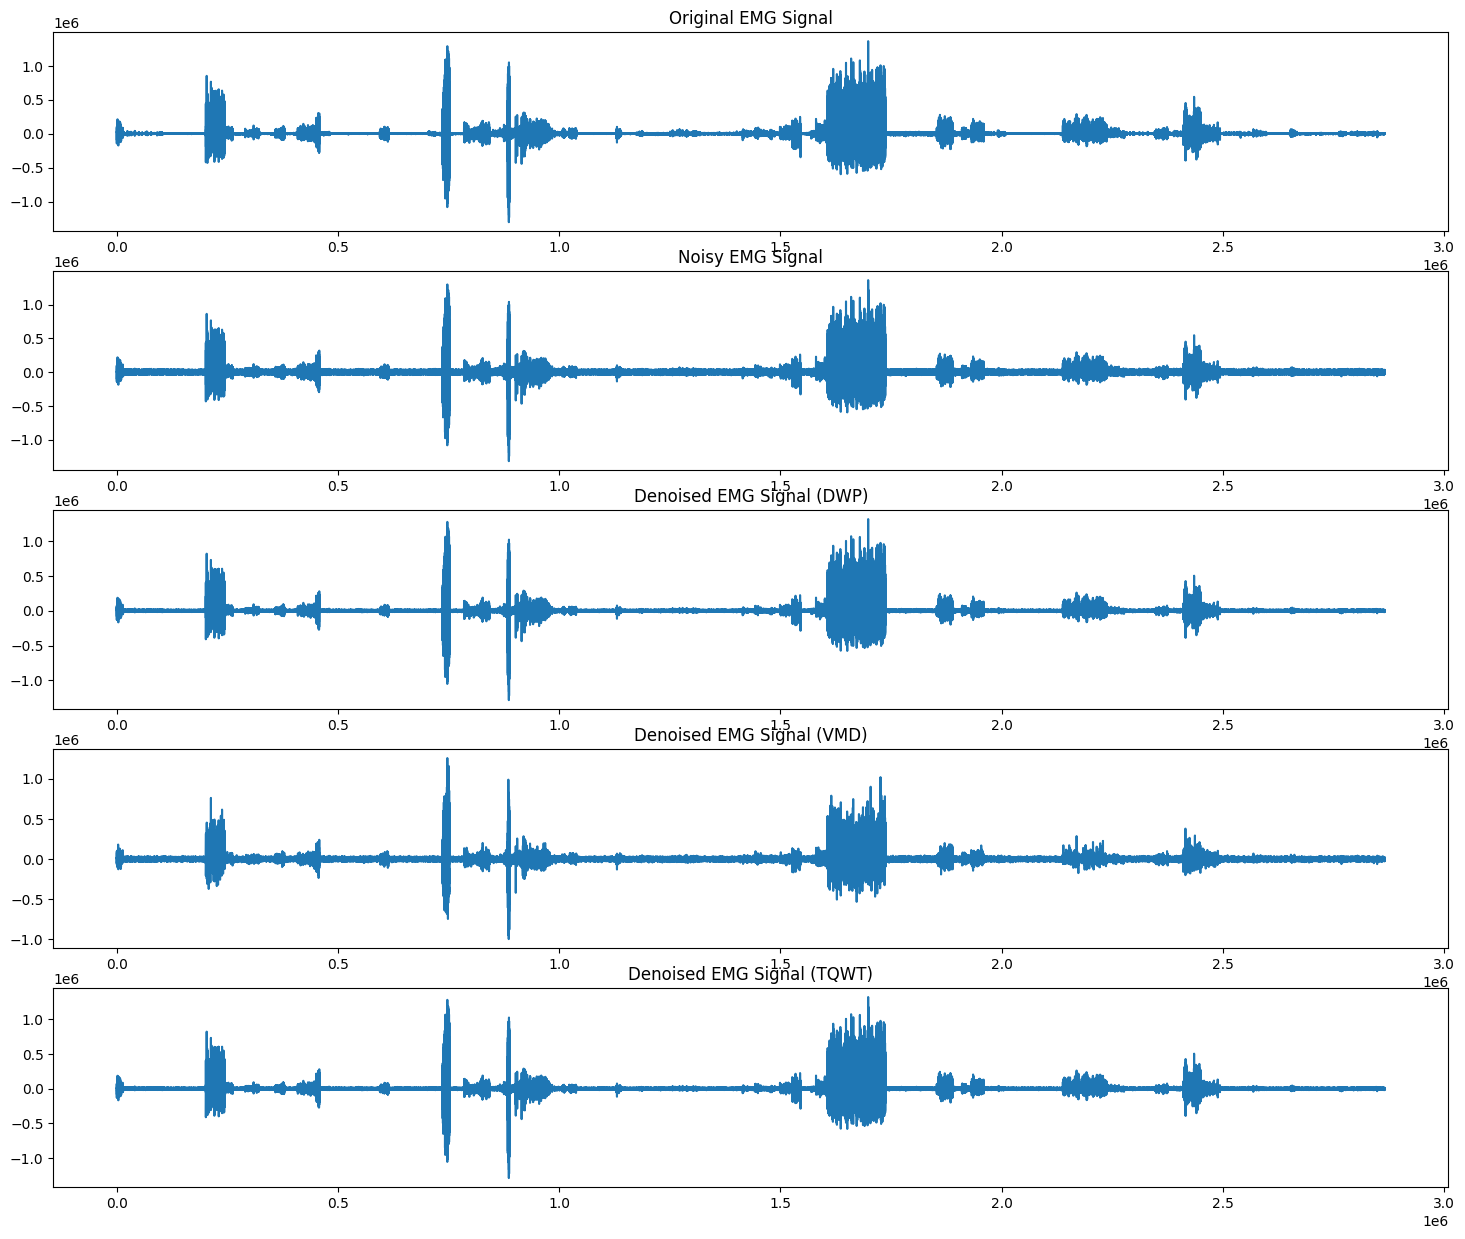

In [53]:
plt.figure(figsize=(18, 15))
plt.subplot(5, 1, 1)
plt.plot(raw_emg, label='Original EMG')
plt.title('Original EMG Signal')

plt.subplot(5, 1, 2)
plt.plot(noisy_emg)
plt.title('Noisy EMG Signal')

plt.subplot(5, 1, 3)
plt.plot(denoised_emg_dwp, label='Denoised EMG (DWP)')
plt.title('Denoised EMG Signal (DWP)')

plt.subplot(5, 1, 4)
plt.plot(denoised_emg_vmd, label='Denoised EMG (VMD)')
plt.title('Denoised EMG Signal (VMD)')

plt.subplot(5, 1, 5)
plt.plot(denoised_emg_tqwt, label='Denoised EMG (TQWT)')
plt.title('Denoised EMG Signal (TQWT)')

Analysis with 40 db noise

In [54]:
snr_dB = 10  
noisy_emg = add_gaussian_noise(raw_emg, snr_dB)

Analysis with the best parameters found with 10 db noise

In [55]:
denoised_emg_dwp = denoise_dwp(noisy_emg, wavelet=best_params_dwp[0], level=best_params_dwp[1])
denoised_emg_vmd = denoise_vmd(noisy_emg, alpha=best_params_vmd[0], tau=best_params_vmd[1], K=best_params_vmd[2])
denoised_emg_tqwt = denoise_tqwt(noisy_emg, wavelet=best_params_tqwt[0], maxlevel=best_params_tqwt[1])

Visualization

Text(0.5, 1.0, 'Denoised EMG Signal (TQWT)')

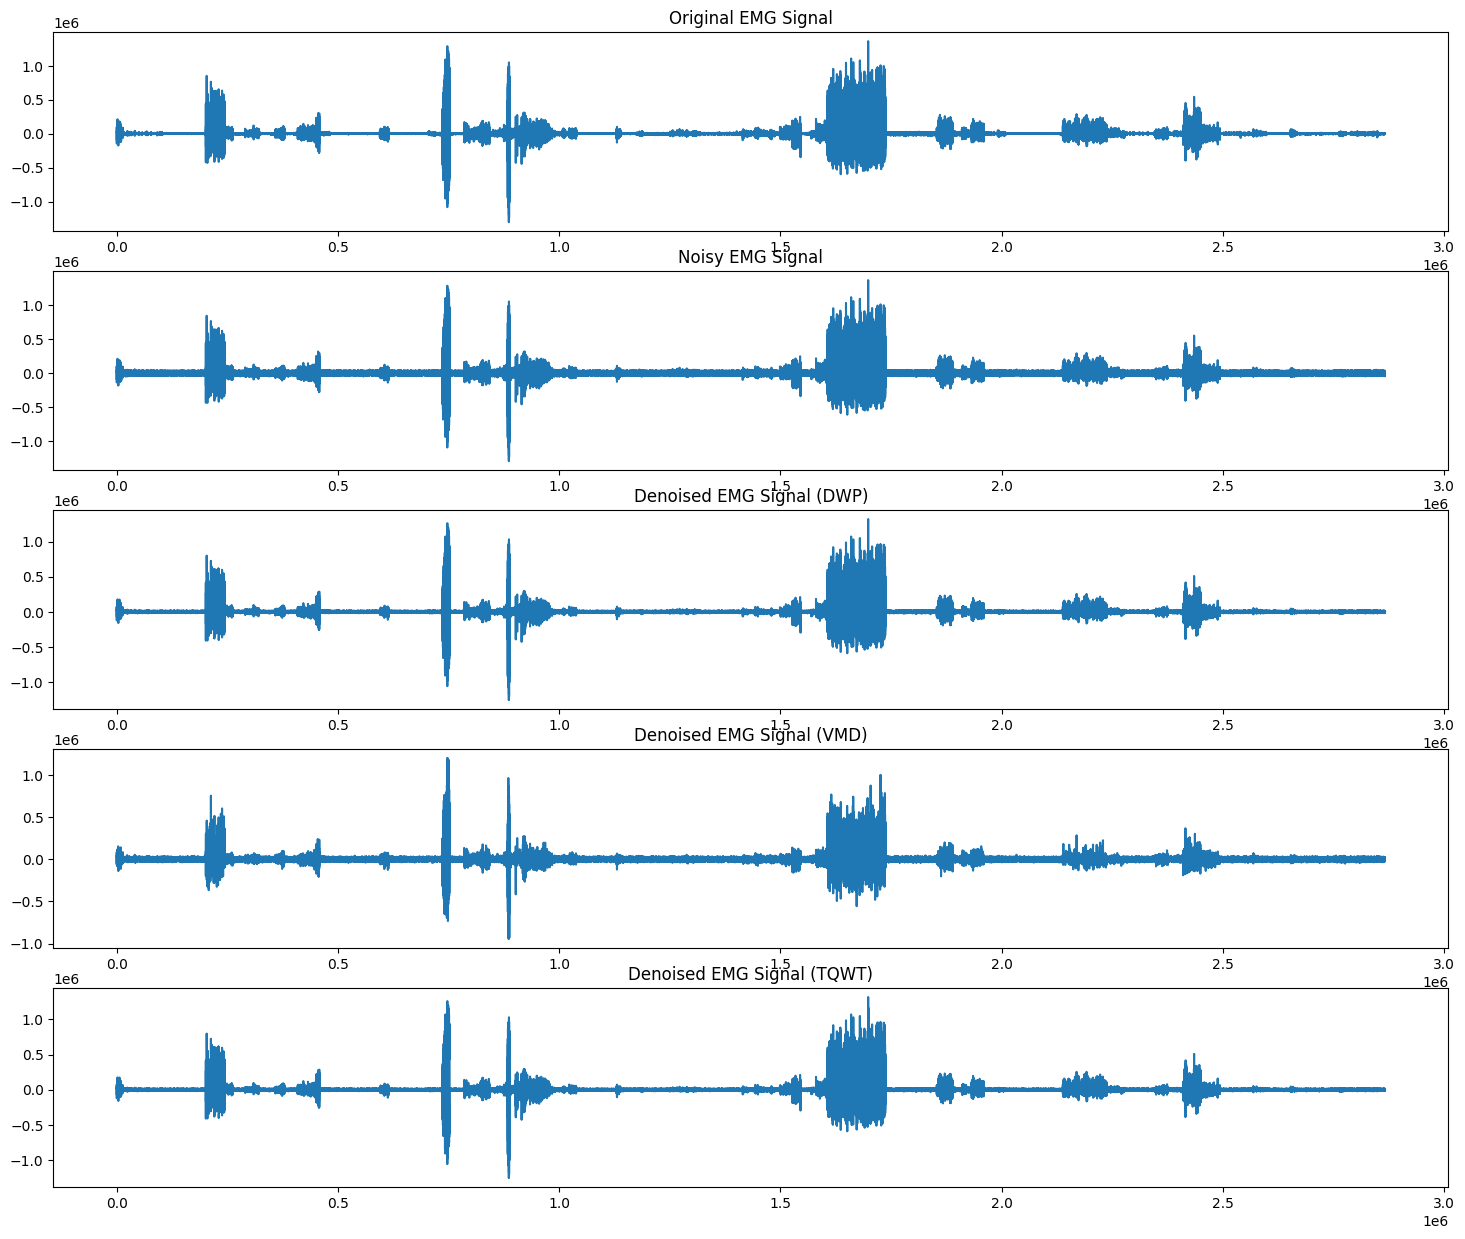

In [56]:
plt.figure(figsize=(18, 15))
plt.subplot(5, 1, 1)
plt.plot(raw_emg, label='Original EMG')
plt.title('Original EMG Signal')

plt.subplot(5, 1, 2)
plt.plot(noisy_emg)
plt.title('Noisy EMG Signal')

plt.subplot(5, 1, 3)
plt.plot(denoised_emg_dwp, label='Denoised EMG (DWP)')
plt.title('Denoised EMG Signal (DWP)')

plt.subplot(5, 1, 4)
plt.plot(denoised_emg_vmd, label='Denoised EMG (VMD)')
plt.title('Denoised EMG Signal (VMD)')

plt.subplot(5, 1, 5)
plt.plot(denoised_emg_tqwt, label='Denoised EMG (TQWT)')
plt.title('Denoised EMG Signal (TQWT)')

Fusing the signals

In [57]:
def fuse_signals(signals, weights=None):

    if weights is None:
        weights = np.ones(len(signals))

    weights = np.array(weights)
    weights = weights / np.sum(weights)

    signal_lengths = [len(signal) for signal in signals]
    min_length = min(signal_lengths)

    trimmed_signals = [signal[:min_length] for signal in signals]

    stacked_signals = np.vstack(trimmed_signals)

    fused_signal = np.average(stacked_signals, axis=0, weights=weights)
    
    return fused_signal

In [58]:
fused_signal = fuse_signals([denoised_emg_dwp, denoised_emg_vmd, denoised_emg_tqwt])

Visualization

Text(0.5, 1.0, 'Fused EMG Signal')

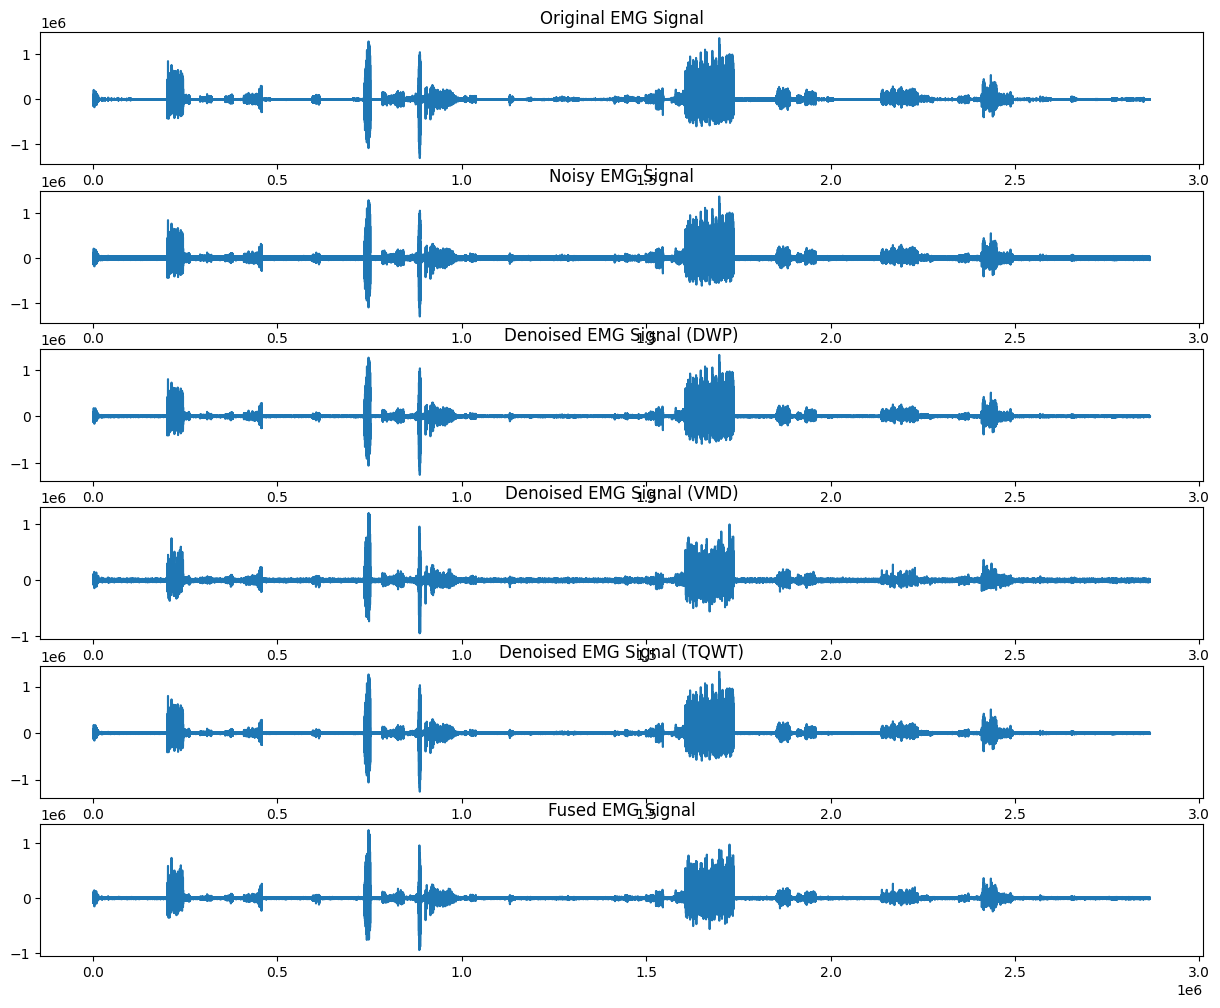

In [61]:
plt.figure(figsize=(15, 12))
plt.subplot(6, 1, 1)
plt.plot(raw_emg, label='Original EMG')
plt.title('Original EMG Signal')

plt.subplot(6, 1, 2)
plt.plot(noisy_emg)
plt.title('Noisy EMG Signal')

plt.subplot(6, 1, 3)
plt.plot(denoised_emg_dwp, label='Denoised EMG (DWP)')
plt.title('Denoised EMG Signal (DWP)')

plt.subplot(6, 1, 4)
plt.plot(denoised_emg_vmd, label='Denoised EMG (VMD)')
plt.title('Denoised EMG Signal (VMD)')

plt.subplot(6, 1, 5)
plt.plot(denoised_emg_tqwt, label='Denoised EMG (TQWT)')
plt.title('Denoised EMG Signal (TQWT)')

plt.subplot(6, 1, 6)
plt.plot(fused_signal, label='Fused EMG Signal')
plt.title('Fused EMG Signal')

Mean square error

In [62]:
def mean_squared_error(original_signal, denoised_signal):
    min_length = min(len(original_signal), len(denoised_signal))
    original_signal = original_signal[:min_length]
    denoised_signal = denoised_signal[:min_length]

    mse = np.mean((original_signal - denoised_signal) ** 2)
    return mse

mse_dwp = mean_squared_error(raw_emg, denoised_emg_dwp)
mse_vmd = mean_squared_error(raw_emg, denoised_emg_vmd)
mse_tqwt = mean_squared_error(raw_emg, denoised_emg_tqwt)
mse_fused = mean_squared_error(raw_emg, fused_signal)

print(f'MSE of DWP denoised signal: {mse_dwp}')
print(f'MSE of VMD denoised signal: {mse_vmd}')
print(f'MSE of TQWT denoised signal: {mse_tqwt}')
print(f'MSE of Fused signal: {mse_fused}')

MSE of DWP denoised signal: 43253681.741651244
MSE of VMD denoised signal: 1458596104.2797287
MSE of TQWT denoised signal: 43791082.26959496
MSE of Fused signal: 215184630.17816484


Sequentially removing noise

In [63]:
denoised_emg_dwp = denoise_dwp(noisy_emg, wavelet=best_params_dwp[0], level=best_params_dwp[1])
denoised_emg_vmd = denoise_vmd(denoised_emg_dwp, alpha=best_params_vmd[0], tau=best_params_vmd[1], K=best_params_vmd[2])
denoised_emg_tqwt = denoise_tqwt(denoised_emg_vmd, wavelet=best_params_tqwt[0], maxlevel=best_params_tqwt[1])

In [64]:
ul=denoised_emg_tqwt

Text(0.5, 1.0, 'Sequential EMG Signal')

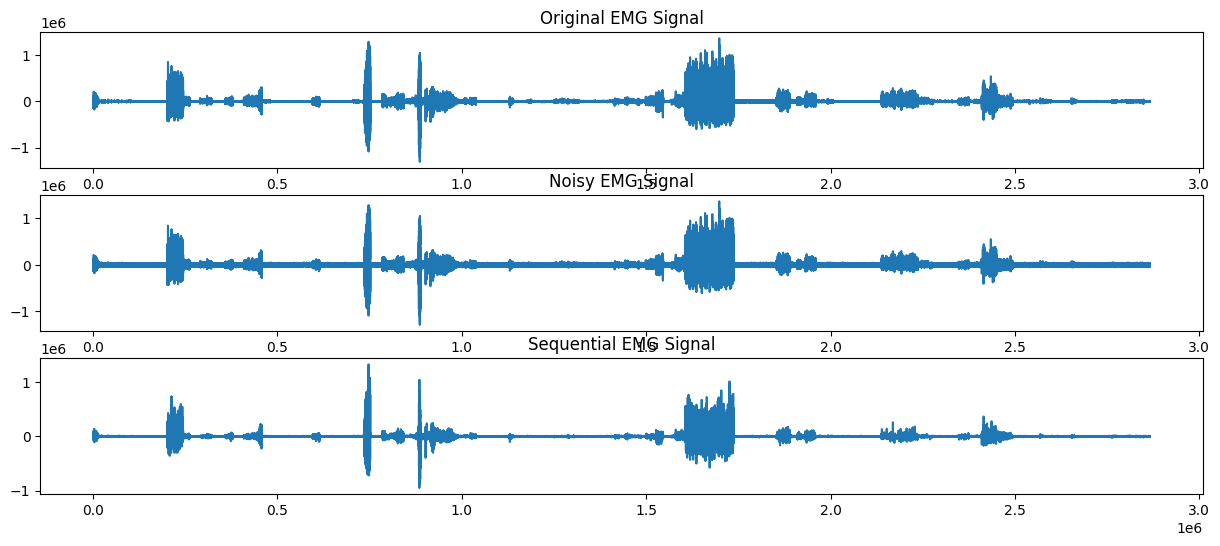

In [66]:
plt.figure(figsize=(15, 6))
plt.subplot(3, 1, 1)
plt.plot(raw_emg, label='Original EMG')
plt.title('Original EMG Signal')

plt.subplot(3, 1, 2)
plt.plot(noisy_emg)
plt.title('Noisy EMG Signal')

plt.subplot(3, 1, 3)
plt.plot(ul, label='Fused EMG Signal')
plt.title('Sequential EMG Signal')

Visualization

In [67]:
mse_seq = mean_squared_error(raw_emg, ul)
print(f'MSE of Fused signal: {mse_seq}')

MSE of Fused signal: 1403556683.389782
